Como o problema de negócio consiste em classificar um cliente numa categoria binária, então se implementará um modelo de regressão logística.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer

training_features = ['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

spark = SparkSession.builder.getOrCreate()
db_cc_training = spark.read.parquet('spark-warehouse/db_cc_training')

train = VectorAssembler(
    inputCols = training_features,
    outputCol = 'features'
)\
    .transform(db_cc_training)\
    .drop('V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17')\
    .withColumnRenamed('Class','label')

test, validate = spark.read.parquet('spark-warehouse/db_cc_norm').randomSplit([0.7, 0.3])

test = VectorAssembler(
    inputCols = training_features,
    outputCol = 'features'
)\
    .transform(test)\
    .drop('Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28')\
    .withColumnRenamed('Class','label')

validate = VectorAssembler(
    inputCols = training_features,
    outputCol = 'features'
)\
    .transform(validate)\
    .drop('Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28')\
    .withColumnRenamed('Class','label')

22/04/01 19:11:18 WARN Utils: Your hostname, freetoaster resolves to a loopback address: 127.0.1.1; using 192.168.1.98 instead (on interface wlo1)
22/04/01 19:11:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/01 19:11:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.ml.classification import LogisticRegression

ITERATIONS = 50
REGPARAM = 0.03
ELASTICNETPARAM = 0.8

logit_reg = LogisticRegression(
    maxIter = ITERATIONS,
    regParam = REGPARAM,
    elasticNetParam = ELASTICNETPARAM
)

In [3]:
logit_reg_model = logit_reg.fit(train)

In [4]:
test_prediction = logit_reg_model.transform(test)

In [9]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

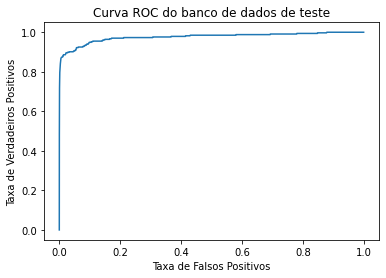

In [16]:
import matplotlib.pyplot as plt

test_probs = test_prediction.select('label', 'probability')\
    .rdd\
    .map(lambda i: (float(i['probability'][1]), float(i['label'])))

test_roc_points = CurveMetrics(test_probs).get_curve('roc')

plt.figure()

x = [x[0] for x in test_roc_points]
y = [x[1] for x in test_roc_points]

plt.plot(x, y)
plt.title('Curva ROC do banco de dados de teste')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

In [5]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

BinaryClassificationEvaluator().evaluate(test_prediction)

0.9760822763389992

Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

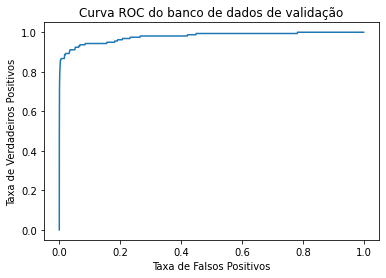

In [17]:
validate_prediction = logit_reg_model.transform(validate)

validate_probs = validate_prediction.select('label', 'probability')\
    .rdd\
    .map(lambda i: (float(i['probability'][1]), float(i['label'])))

validate_roc_points = CurveMetrics(validate_probs).get_curve('roc')

plt.figure()

x = [x[0] for x in validate_roc_points]
y = [x[1] for x in validate_roc_points]

plt.plot(x, y)
plt.title('Curva ROC do banco de dados de validação')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

In [6]:
BinaryClassificationEvaluator().evaluate(validate_prediction)

0.9781950172446482

In [8]:
logit_reg_model.write().overwrite().save('antifraud_logit_model')